In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import numpy as np
from vcf_parser import VCFParser
import polars as pl
import matplotlib.pyplot as plt
from sort_src.fold_utils import generate_point_mutations, get_all_metrics, plot_structure
from tqdm import tqdm
from cmap import Colormap

/opt/homebrew/anaconda3/envs/sort_env/lib/python3.10/site-packages/vcf_parser/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import require


### data preprocessing

The following Snakemake pipeline defines the data processing steps for the amplicon sequencing workflow.

```Snakemake
rule fastp_merge:
    input:
        r1=config['DATAPATH'] + "{sample}_R1.fastq.gz",
        r2=config['DATAPATH'] + "{sample}_R2.fastq.gz"
    output:
        r=config['OUTPUTPATH'] + "fastq/{sample}_fp.fastq.gz",
        r1=config['OUTPUTPATH'] + "fastq/{sample}_R1_long_fp.fastq.gz",
        r2=config['OUTPUTPATH'] + "fastq/{sample}_R2_long_fp.fastq.gz",
        html=config['OUTPUTPATH'] + "fastq/{sample}_fastp.html",
        json=config['OUTPUTPATH'] + "fastq/{sample}_fastp.json"
    threads: 8
    params:
        l=config['MINREADLENGTH']
    shell:
        "fastp -l {params.l} -c --trim_poly_g --merge --overlap_len_require 10 "
        "-w {threads} --json {output.json} --html {output.html} "
        "-i {input.r1} -I {input.r2} --merged_out {output.r} "
        "--out1 {output.r1} --out2 {output.r2}"

rule bwa_index:
    input:
        ancient(config['GENOMEFASTA'])
    output:
        config['GENOMEFASTA'] + ".sa"
    shell:
        "bwa index {input}"

rule bwa_mem:
    input:
        sample=config['OUTPUTPATH'] + "fastq/{sample}_fp.fastq.gz",
        requir=config['GENOMEFASTA'] + ".sa",
        genome=config['GENOMEFASTA']
    output:
        temp(config['OUTPUTPATH'] + "bam/{sample}.sam")
    params:
        m="500M",
    threads: config['THREADS']
    shell:
        "bwa mem -M -t {threads} {input.genome} {input.sample} > {output}"

rule picard_index:
    input:
        config['GENOMEFASTA']
    output:
        fai=config['GENOMEFASTA'] + ".fai",
        dict=config['GENOMEFASTA'] + ".dict"
    shell:
        '''
        java -jar $EBROOTPICARD/picard.jar CreateSequenceDictionary R={input} O={output.dict}
        samtools faidx {input}

rule add_rg:
    input:
        config['OUTPUTPATH'] + "bam/{sample}.sam"
    output:
        temp(config['OUTPUTPATH'] + "bam/{sample}_rg.sam")
    shell:
        "samtools addreplacerg -r '@RG\tID:samplename\tSM:samplename' {input} -o {output}"

rule picard_sort:
    input:
        config['OUTPUTPATH'] + "bam/{sample}_rg.sam"
    output:
        temp(config['OUTPUTPATH'] + "bam/{sample}_sort.bam")
    shell:
        "java -jar $EBROOTPICARD/picard.jar SortSam INPUT={input} OUTPUT={output} SORT_ORDER=coordinate"

rule recalibrate:
    input:
        bam=config['OUTPUTPATH'] + "bam/{sample}_sort.bam",
        genome=config['GENOMEFASTA']
    output:
        bam=config['OUTPUTPATH'] + "bam/{sample}_recal.bam",
        bai=config['OUTPUTPATH'] + "bam/{sample}_recal.bam.bai"
    shell:
        '''
        lofreq indelqual --dindel -f {input.genome} -o {output.bam} {input.bam}
        samtools index {output.bam}
```

### mutation rate calculation

Run `samtools mpileup` for all variants of interest

```bash
samtools mpileup -d 0 -q 20 -Q 20 -f kan_stem.fsa kan_stem_nouv_200_recal.bam > kan_stem_nouv_200.pileup
samtools mpileup -d 0 -q 20 -Q 20 -f kan_stem.fsa kan_stem_uv_200_recal.bam > kan_stem_uv_200.pileup
samtools mpileup -d 0 -q 20 -Q 20 -f kan_stem.fsa kan_stem_uv_1500_recal.bam > kan_stem_uv_1500.pileup
samtools mpileup -d 0 -q 20 -Q 20 -f kan_intronless.fsa kan_intronless_uv_200_recal.bam > kan_intronless_uv_200.pileup
samtools mpileup -d 0 -q 20 -Q 20 -f kan_intronless.fsa kan_intronless_uv_1500_recal.bam > kan_intronless_uv_1500.pileup
samtools mpileup -d 0 -q 20 -Q 20 -f kan_intronless.fsa kan_intronless_nouv_200_recal.bam > kan_intronless_nouv_200.pileup
samtools mpileup -d 0 -q 20 -Q 20 -f kan_intronless.fsa kan_intronless_nouv_1500_recal.bam > kan_intronless_nouv_1500.pileup
```

In [3]:
def count_mismatches(base_str):
    """Count matching and mismatching bases from the pileup base string."""
    match = 0
    mismatch = 0
    i = 0
    while i < len(base_str):
        c = base_str[i]

        if c in '.,':
            match += 1
        elif c in 'ACGTNacgtn':
            mismatch += 1
        elif c == '^':  # start of a read, skip next char (mapping quality)
            i += 1
        elif c == '$':  # end of a read segment
            pass
        elif c in '+-':  # insertion or deletion
            i += 1
            indel_len = ''
            while i < len(base_str) and base_str[i].isdigit():
                indel_len += base_str[i]
                i += 1
            i += int(indel_len) - 1  # skip the indel bases
        # ignore other symbols
        i += 1
    return match, mismatch

def compute_mutation_rates(pileup_path):
    """
    Reads a samtools pileup file and returns:
    - chroms: list of chromosome/contig names
    - positions: np.array of 1-based positions
    - coverage: np.array of read depth per position
    - mutations: np.array of non-reference base counts per position
    """
    chroms = []
    positions = []
    coverage = []
    mutations = []

    with open(pileup_path) as infile:
        for line in infile:
            fields = line.strip().split("\t")
            if len(fields) < 5:
                continue
            chrom, pos_str, _, depth_str, base_str = fields[:5]
            pos = int(pos_str)
            depth = int(depth_str)
            _, mismatch = count_mismatches(base_str)

            chroms.append(chrom)
            positions.append(pos)
            coverage.append(depth)
            mutations.append(mismatch)

    return(np.array(chroms), np.array(positions), np.array(coverage), np.array(mutations))

In [ ]:
path = 'YOUR_PILEUP_PATH_HERE/'

pileup_files = {'41_uv_15':    path + 'kan_stem_uv_1500.pileup',
                '41_uv_02':    path + 'kan_stem_uv_200.pileup',
                '40_41_no_02': path + 'kan_stem_nouv_200.pileup',
                'iL_no_02':    path + 'kan_intronless_nouv_200.pileup',
                'iL_no_15':    path + 'kan_intronless_nouv_1500.pileup',
                'iL_uv_02':    path + 'kan_intronless_uv_200.pileup',
                'iL_uv_15':    path + 'kan_intronless_uv_1500.pileup'}

rats = {}
for pu in tqdm(pileup_files):
    chroms, pos, cov, mut = compute_mutation_rates(pileup_files[pu])
    if len(set(chroms)) == 1:
        rats[pu] = mut/cov
    else:
        for chrom in set(chroms):
            rats[pu + '_' + chrom] = mut[chroms==chrom]/cov[chroms==chrom]

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [09:05<00:00, 77.98s/it]


## Figure 6a

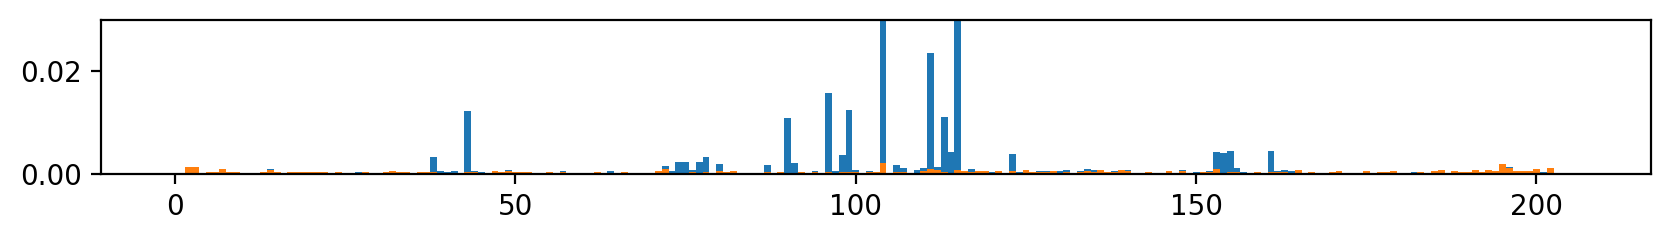

In [5]:
plt.figure(figsize=[10,1])
plt.bar(np.arange(len(rats['41_uv_15'])), rats['41_uv_15'], 1)
plt.bar(np.arange(len(rats['41_uv_02'])), rats['41_uv_02'], 1)
plt.ylim([0, 0.03])
plt.show()

## Figure 6b

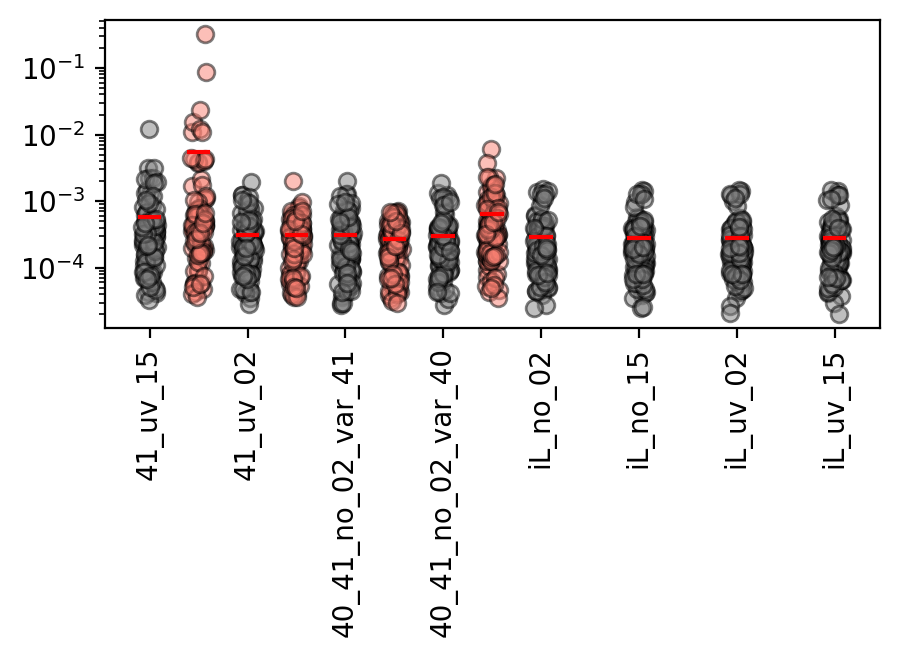

In [6]:
def x_univar(n, spread=0.3):
    return(spread*(np.random.rand(n)-0.5))

plt.figure(figsize=[5,2])
for i, ds in enumerate(rats):
    if len(rats[ds]) == 207:
        pos = np.arange(207)+1
        exon_msk = ((pos < 86) | (pos > 187))
        x2 = 2*i+1+x_univar(np.sum(~exon_msk))
        plt.scatter(x2, rats[ds][~exon_msk], color='salmon', alpha=0.5, edgecolors='k')
        plt.plot([2*i+1-0.2, 2*i+1+0.2], 2*[np.mean(rats[ds][~exon_msk])], 'r-')
    else:
        exon_msk = np.ones(len(rats[ds]), dtype=bool)

    x1 = 2*i+x_univar(np.sum(exon_msk))
    plt.scatter(x1, rats[ds][exon_msk], color='gray', alpha=0.5, edgecolors='k')
    plt.plot([2*i-0.2, 2*i+0.2], 2*[np.mean(rats[ds][exon_msk])], 'r-')

plt.xticks(np.arange(0, 15, 2), rats.keys(), rotation=90)
plt.yscale('log')
plt.show()

## Figure 6c

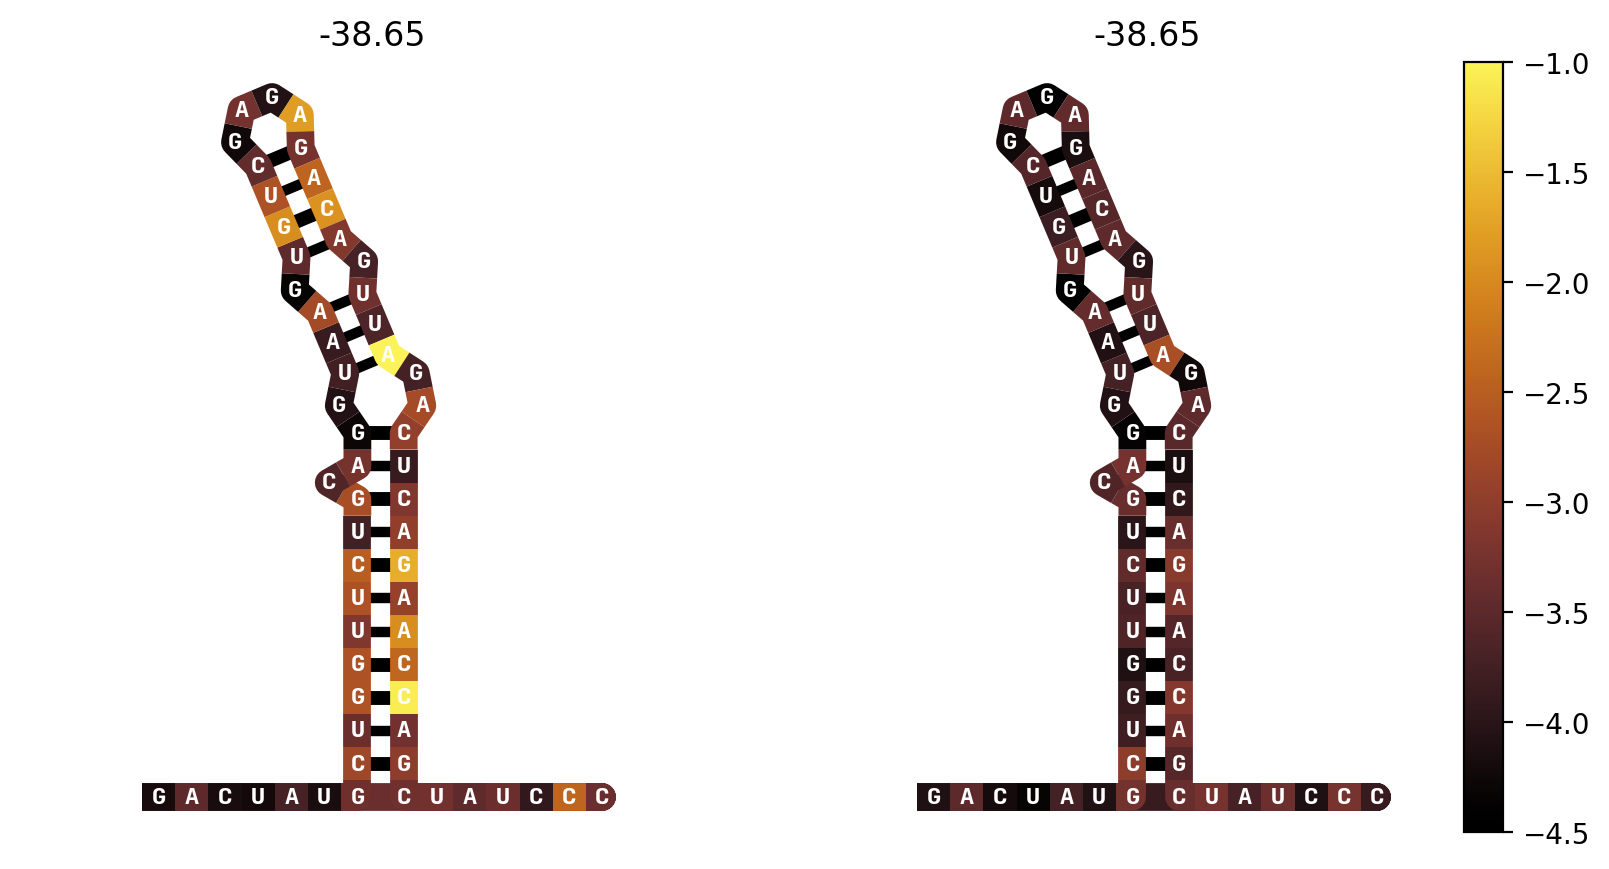

In [7]:
v_41 = 'AGAACTTAGTTTCGAATAAACACACATAAACAAACAAATCTAGAATGTACCCATACGATGTTCCTGACTATGCTGGTTCTGCAGGTAAGTGTCGAGAGACAGTTAGACTCAGAACCAGCTATCCCTACTCATCCTATCATATTATGTGAGCTAGAACCGAATTAGTATACTAACATTTATAATACAGGTGTCTCTAAGGGTGAAGAA'


af_col = [np.log10(rats['41_uv_15'][49:155]), np.log10(rats['41_uv_02'][49:155])]

bpp_sel, _, _, dbr_sel, _, dbr_efe_sel, efe_sel, _, _, _ = get_all_metrics([v_41[49:155]]*2, n_cpu=2)

fig, axs = plt.subplots(1, 2, figsize=[10, 5])

cmap = Colormap('cmasher:amber').to_mpl()

for i in range(len(af_col)):
    
    seq_plot = v_41[49:155]

    axs[i].set_title(f"{efe_sel[i]:.2f}")
    
    m = plot_structure(seq_plot[15:77], dbr_sel[i][15:77], af_col[i][15:77], np.array([True]*len(seq_plot))[15:77], axs=axs[i], cmap=cmap, line_width=10, bp_width=5, text_size=8, vmin=-4.5, vmax=-1)

fig.colorbar(m, ax=axs[1])
plt.show()


To get allele frequencies, next we run LoFreq:

```bash
lofreq call --call-indels -f ../config/fasta_files/kan_stem.fsa -o ../data/vcf/kan_stem_uv_200.vcf ../data/bam/kan_stem_uv_200_recal.bam
lofreq call --call-indels -f ../config/fasta_files/kan_stem.fsa -o ../data/vcf/kan_stem_uv_1500.vcf ../data/bam/kan_stem_uv_1500_recal.bam
lofreq call --call-indels -f ../config/fasta_files/kan_stem_mixed.fsa -o ../data/vcf/kan_stem_nouv_200.vcf ../data/bam/kan_stem_nouv_200_recal.bam
lofreq call --call-indels -f ../config/fasta_files/kan_intronless.fsa -o ../data/vcf/kan_intronless_uv_200.vcf ../data/bam/kan_intronless_uv_200_recal.bam
lofreq call --call-indels -f ../config/fasta_files/kan_intronless.fsa -o ../data/vcf/kan_intronless_uv_1500.vcf ../data/bam/kan_intronless_uv_1500_recal.bam
lofreq call --call-indels -f ../config/fasta_files/kan_intronless.fsa -o ../data/vcf/kan_intronless_nouv_200.vcf ../data/bam/kan_intronless_nouv_200_recal.bam
lofreq call --call-indels -f ../config/fasta_files/kan_intronless.fsa -o ../data/vcf/kan_intronless_nouv_1500.vcf ../data/bam/kan_intronless_nouv_1500_recal.bam
```

In [8]:
def parse_vcf(fname, min_depth=10000):
    my_parser = VCFParser(infile=fname, split_variants=True, check_info=True)

    chroms = []
    posits = []
    frequs = []
    refs = []
    alts = []
    depths = []
    for variant in my_parser:
        chroms.append(variant['CHROM'])
        posits.append(int(variant['POS']))
        refs.append(variant['REF'])
        alts.append(variant['ALT'])
        frequs.append(float(variant['info_dict']['AF'][0]))
        depths.append(int(variant['info_dict']['DP'][0]))

    df = pl.DataFrame({'chrom': chroms, 'pos': posits, 'AF': frequs, 'DP': depths, 'REF': refs, 'ALT': alts})
    df = df.filter(pl.col('DP') >= min_depth)

    return(df)

def x_univar(n, spread=0.3):
    return(spread*(np.random.rand(n)-0.5))

def sum_af_pos(vcf_df):
    x = np.arange(1, np.max(vcf_df['pos'].astype(int)) + 1, 1)
    y = []
    for i in x:
        if i in list(vcf_df['pos'].astype(int)):
            y.append(np.sum(vcf_df['AF'][vcf_df['pos'].astype(int)==i]))
        else:
            y.append(0)
    return(x, np.array(y))

In [9]:
# vcf files are provided as suppolemental files in the GEO repository

uv_41_02 = parse_vcf('../data/vcf/kan_stem_uv_200.vcf')
uv_41_15 = parse_vcf('../data/vcf/kan_stem_uv_1500.vcf')
no_41_02 = parse_vcf('../data/vcf/kan_stem_nouv_200.vcf').filter(pl.col('chrom')=='var_41')

uv_il_02 = parse_vcf('../data/vcf/kan_intronless_uv_200.vcf')
uv_il_15 = parse_vcf('../data/vcf/kan_intronless_uv_1500.vcf')
no_il_02 = parse_vcf('../data/vcf/kan_intronless_nouv_200.vcf')
no_il_15 = parse_vcf('../data/vcf/kan_intronless_nouv_1500.vcf')

In [10]:
print(uv_41_15.filter(pl.col('AF')>=0.0095))

shape: (6, 6)
┌────────┬─────┬──────────┬─────────┬─────┬─────┐
│ chrom  ┆ pos ┆ AF       ┆ DP      ┆ REF ┆ ALT │
│ ---    ┆ --- ┆ ---      ┆ ---     ┆ --- ┆ --- │
│ str    ┆ i64 ┆ f64      ┆ i64     ┆ str ┆ str │
╞════════╪═════╪══════════╪═════════╪═════╪═════╡
│ var_41 ┆ 44  ┆ 0.011265 ┆ 1000002 ┆ A   ┆ T   │
│ var_41 ┆ 97  ┆ 0.016089 ┆ 1000038 ┆ A   ┆ G   │
│ var_41 ┆ 105 ┆ 0.327732 ┆ 1000036 ┆ A   ┆ G   │
│ var_41 ┆ 112 ┆ 0.014088 ┆ 1000041 ┆ G   ┆ A   │
│ var_41 ┆ 114 ┆ 0.00974  ┆ 1000042 ┆ A   ┆ T   │
│ var_41 ┆ 116 ┆ 0.081461 ┆ 1000043 ┆ C   ┆ T   │
└────────┴─────┴──────────┴─────────┴─────┴─────┘


## Figure 6d

In [11]:
def generate_mutant_seqs(df, ref_seq):

    mutants = []
    for row in df.iter_rows():
        pos = int(row[1]) - 1  # Convert 1-based to 0-based
        ref = row[4]
        alt = row[5]

        # Check that reference matches
        ref_orig = ref_seq[pos:pos+len(ref)]
        if ref_orig != ref:
            raise ValueError(f"Reference mismatch at position {pos+1}: expected '{ref}', found '{ref_orig}'")

        # Replace REF with ALT
        repl = list(ref_seq)
        repl[pos:pos+len(ref)] = list(alt)

        mutants.append(''.join(repl))   
    return(mutants)

In [12]:
mutants = generate_mutant_seqs(uv_41_15, v_41)

# predict structure
c_sta = 65
c_end = 126 

mutants_pred = []
for mutant in mutants:
    predict_start = mutant.find(v_41[c_sta:c_end][:6])
    predict_end   = mutant.find(v_41[c_sta:c_end][-6:])

    if predict_start > 0 and predict_end > 0 and mutant[predict_start:predict_end+6] != v_41[c_sta:c_end]:
        if mutant[predict_start:predict_end+6] in mutants_pred:
            print(mutant)
        mutants_pred.append(mutant[predict_start:predict_end+6])
        
    else:
        mutants_pred.append('GGG')

bpp_mut, _, _, dbr_mut, _, dbr_efe_mut, efe_mut, _, _, _ = get_all_metrics(mutants_pred, n_cpu=4)
bpp_ref, _, _, dbr_ref, _, dbr_efe_ref, efe_ref, _, _, _ = get_all_metrics([v_41[c_sta:c_end]], n_cpu=1)

efe_mut = np.array(efe_mut) / np.array([len(i) for i in mutants_pred])
efe_ref = efe_ref[0] / len(v_41[c_sta:c_end])

# all possible point mutations
pms = generate_point_mutations(v_41[c_sta:c_end], (c_end-c_sta)*'N', 1)
bpp_pms, _, _, dbr_pms, _, dbr_efe_pms, efe_pms, _, _, _ = get_all_metrics(pms, n_cpu=6)
efe_pms = efe_pms / len(v_41[c_sta:c_end])

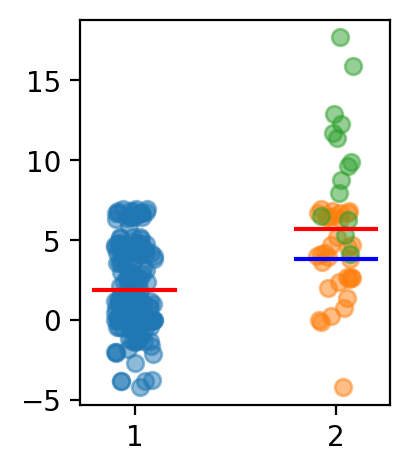

In [13]:
plt.figure(figsize=[2,2.5])
msk_ggg = np.array(mutants_pred)!='GGG'

indel_mask = np.array([len(i) != len(v_41[c_sta:c_end]) for i in mutants_pred])

diff_pms = (abs(efe_ref)-abs(efe_pms)) * len(v_41[c_sta:c_end])
diff_mut_poi = (abs(efe_ref)-abs(efe_mut[msk_ggg&~indel_mask])) * len(v_41[c_sta:c_end])
diff_mut_ind = (abs(efe_ref)-abs(efe_mut[msk_ggg&indel_mask])) * len(v_41[c_sta:c_end])

plt.scatter(1+x_univar(len(diff_pms), spread=0.2), diff_pms, alpha=0.5)
plt.plot([1-0.2, 1+0.2], 2*[np.mean(diff_pms)], 'r-')
plt.scatter(2+x_univar(len(diff_mut_poi), spread=0.2), diff_mut_poi, alpha=0.5)
plt.scatter(2+x_univar(len(diff_mut_ind), spread=0.2), diff_mut_ind, alpha=0.5)
plt.plot([2-0.2, 2+0.2], 2*[np.mean(np.hstack([diff_mut_poi, diff_mut_ind]))], 'r-')
plt.plot([2-0.2, 2+0.2], 2*[np.mean(diff_mut_poi)], 'b-')

plt.show()